# Estudio de sueldos de contrata del sector público

* Sólo año 2016
* Sin considerar asignaciones especiales

## Uso de lxml

In [33]:
# Carga de librerías
import requests
import urllib.request
from lxml import html
from bs4 import BeautifulSoup
import pandas as pd
from ggplot import *

%matplotlib inline

In [34]:
# Para representar en moneda con "$ y ."
# pd.set_option("display.float_format",lambda x: "{:,}".format(x).replace(",","."))

In [35]:
# Extracción desde URL
url = 'http://www.gobiernotransparentechile.cl/directorio/servicios'
headers = {'User-Agent': 'My User Agent 1.0'}
page = requests.get(url, headers = headers)
tree = html.fromstring(page.content)

In [36]:
# Listado de servicios
servicios = tree.xpath("//ul[@class='resultList']/li/a/text()")

In [37]:
servicios[0:5]

['Agencia de Cooperación Internacional (AGCI)',
 'Agencia Nacional de Inteligencia (ANI)',
 'Armada de Chile',
 'Caja de Previsión de la Defensa Nacional (CAPREDENA)',
 'Carabineros de Chile']

In [59]:
len(servicios)

347

In [38]:
# URLs asociadas a servicios
links = tree.xpath("//ul[@class='resultList']/li/a/@href")

In [39]:
# Añadimos link a personas a contrata
links = [s + '/per_contrata/Ao-2016?x=0&y=0&sort=id&direction=asc&page_number=' for s in links]

## Uso de BeautifulSoup

In [41]:
def get_html(link):
    '''
    Devuelve el contenido html de un link asociado
    '''
    headers = {'User-Agent': 'My User Agent 1.0'}
    req = urllib.request.Request(link, data=None, headers=headers)    
    try:
        f = urllib.request.urlopen(req)        
        html = f.read().decode('utf-8')
        return html
    except:
        return

def extract_table(html):
    soup = BeautifulSoup(html,'lxml')
    main_div = soup.find('div', {'id': 'main'})
    main_table = main_div.find('table')    
    if main_table:
        return main_table
    else:
        return

def create_df(table,servicio):    
    '''Cabecera'''
    thead = main_table.find('thead')
    rows = thead.find('tr')
    titles = [s.text.strip() for s in rows.find_all('th')]

    '''Filas'''
    tbody = main_table.find('tbody')
    rows = tbody.find_all('tr')
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols])
    df = pd.DataFrame(data)
    df = df.dropna()
    df.reset_index(drop=True,inplace=True)
    df.columns = titles
    df['Remuneración Bruta Mensualizada'] = df['Remuneración Bruta Mensualizada'].str.replace('.','').astype(float)
    df = df[['Estamento','Cargo','Grado EUS','Remuneración Bruta Mensualizada','Fecha de inicio','Fecha de término']]
    df['servicio'] = servicio
    return df

In [61]:
%time
df = pd.DataFrame()

for i in [s for s in list(range(0,len(links)))]:
    n_page = 1
    link = links[i]
    servicio = servicios[i]
    print('Procesando servicio ' + str(i+1) + ':' + servicio)
    main_html = get_html(link + str(n_page))

    if main_html:    
        main_table = extract_table(main_html)
        if main_table:
            try:
                df_1 = create_df(main_table,servicio)
                df = pd.concat([df,df_1])
            except:
                continue
            while True:
                n_page = n_page + 1  
                sub_html = get_html(link + str(n_page))
                sub_table = extract_table(sub_html)
                # Se pone un factor de seguridad de un máximo de 10 páginas...
                if sub_table and n_page<50:
                    df_extra = create_df(sub_table,servicio)
                    df = pd.concat([df,df_extra])
                else:
                    break

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Procesando servicio 1:Agencia de Cooperación Internacional (AGCI)
Procesando servicio 2:Agencia Nacional de Inteligencia (ANI)
Procesando servicio 3:Armada de Chile
Procesando servicio 4:Caja de Previsión de la Defensa Nacional (CAPREDENA)
Procesando servicio 5:Carabineros de Chile
Procesando servicio 6:Central de Abastecimiento del Sistema Nacional de Servicios de Salud (CENABAST)
Procesando servicio 7:Centro de Referencia de Salud de Maipú
Procesando servicio 8:Centro de Referencia de Salud de Peñalolén Cordillera Oriente
Procesando servicio 9:Comisión Administradora del Sistema de Créditos para Estudios Superiores
Procesando servicio 10:Comisión Chilena de Energía Nuclear (CCHEN)
Procesando servicio 11:Comisión Chilena del Cobre (COCHILCO)
Procesando servicio 12:Comisión del Sistema Nacional de Certificación de Competencias Laborales (CHILEVALORA)
Procesando servicio 13:Comisión Nacional de Acreditación (CNA)
Procesando

In [62]:
df.shape

(16241, 7)

In [63]:
df.head()

,Estamento,Cargo,Grado EUS,Remuneración Bruta Mensualizada,Fecha de inicio,Fecha de término,servicio
0,PROFESIONAL,JEFA UNIDAD COMUNICACIONES,4°,3639594.0,01/08/2014,31/12/2016,Caja de Previsión de la Defensa Nacional (CAPR...
1,PROFESIONAL,ASESOR DE VICEPRESIDENCIA,4°,3900396.0,01/03/2015,05/06/2016,Caja de Previsión de la Defensa Nacional (CAPR...
2,PROFESIONAL,JEFA AUDITORIA INTERNA,4°,2911675.0,22/12/2011,31/12/2016,Caja de Previsión de la Defensa Nacional (CAPR...
3,PROFESIONAL,JEFE DEPTO. CONTABILIDAD,6°,2379684.0,26/05/2014,31/12/2016,Caja de Previsión de la Defensa Nacional (CAPR...
4,PROFESIONAL,ASESOR LEGAL DE LOS CDS y R,7°,2393036.0,02/01/1996,31/12/2016,Caja de Previsión de la Defensa Nacional (CAPR...


In [45]:
df['servicio'].unique()

array(['Caja de Previsión de la Defensa Nacional (CAPREDENA)',
       'Comité de Inversiones Extranjeras',
       'Consejo de Rectores de las Universidades Chilenas',
       'Corporación Nacional de Desarrollo Indígena (CONADI)',
       'Dirección de Compras y Contratación Pública (Chilecompra)',
       'Dirección de Presupuestos (DIPRES)',
       'Dirección General de Relaciones Económicas Internacionales (DIRECON)',
       'Dirección Nacional de Fronteras y Límites del Estado (DIFROL)',
       'Dirección Nacional del Servicio Civil',
       'Fiscalía Nacional Económica (FNE)', 'Gobierno Regional de Aysén',
       'Gobierno Regional de Los Lagos', "Gobierno Regional de O'Higgins",
       'Gobierno Regional Metropolitano de Santiago',
       'Instituto de Desarrollo Agropecuario (INDAP)',
       'Instituto de Seguridad Laboral (ISL)',
       'Instituto Nacional de Estadísticas (INE)',
       'Instituto Nacional de Propiedad Industrial (INAPI)',
       'Junta de Aeronáutica Civil',
    

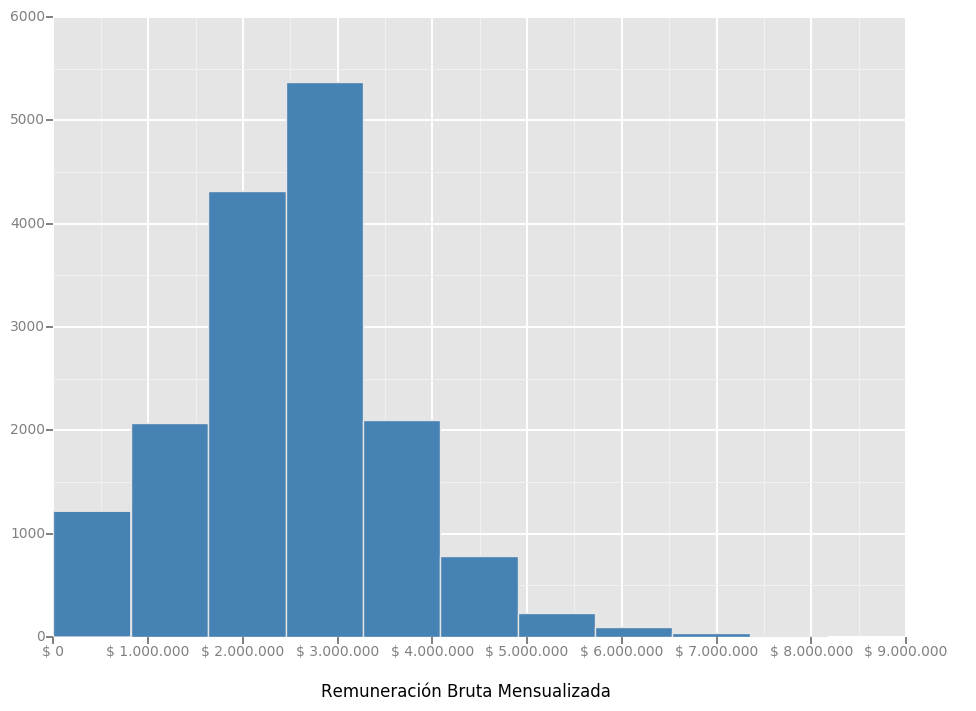

<ggplot: (-9223372036560767144)>

In [46]:
labels = ['$ {0:,}'.format(n*1000000).replace(',','.') for n in list(range(10))]
ggplot(df,aes(x='Remuneración Bruta Mensualizada'))+geom_histogram(aes(fill='steelblue')) + \
scale_x_continuous(labels=labels)


In [65]:
#pd.set_option("display.float_format",lambda x: "$ {:,.0f}".format(x).replace(",","."))

In [66]:
df.describe()[1:]

,Remuneración Bruta Mensualizada
mean,2.513467e+06
std,1.137825e+06
min,0.000000e+00
25%,1.829904e+06
50%,2.557620e+06
75%,3.133074e+06
max,8.168166e+06


In [64]:
pd.reset_option("display.float_format")

In [58]:
df.to_pickle('sueldos_contrata.pkl')